In [1]:
# 📌 Neural Style Transfer - Step 1: Import Libraries and Setup Device

# PyTorch and vision libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

# Image loading & display
from PIL import Image
import matplotlib.pyplot as plt

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


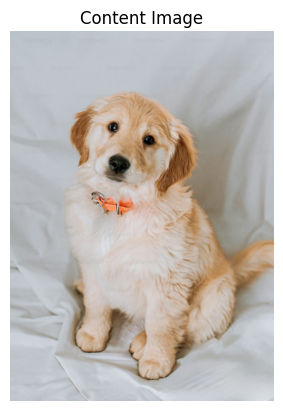

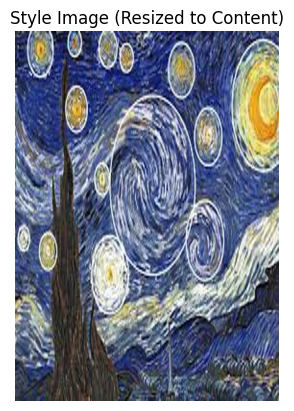

In [18]:
# 📌 Neural Style Transfer - Step 2: Load and Preprocess Images
from torchvision.transforms import ToPILImage

# Transform: convert to tensor only (no resize)
loader = transforms.Compose([
    transforms.ToTensor()
])

# Load content image first
def load_content_image(image_name):
    image = Image.open(image_name).convert("RGB")
    image = image.resize((512, int(image.height * 512 / image.width)))
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float), image.size()  # tensor and size

# Load style image and resize to given size
def load_style_image(image_name, target_size):
    image = Image.open(image_name).convert("RGB")
    image = image.resize((target_size[3], target_size[2]))  # size in tensor is [B,C,H,W]
    image = image.resize((512, int(image.height * 512 / image.width)))
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Load content image (update path!)
content_img, content_size = load_content_image("premium_photo-1694819488591-a43907d1c5cc.jpeg")

# Load style image resized to content image's size
style_img = load_style_image("images.jpeg", content_size)

# Display helper
unloader = ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Show images
imshow(content_img, title="Content Image")
imshow(style_img, title="Style Image (Resized to Content)")


In [19]:
# 📌 Neural Style Transfer - Step 3: Load VGG19 and Select Layers

# Load pre-trained VGG19 model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# We won't train the model — freeze all parameters
for param in cnn.parameters():
    param.requires_grad = False

# Define normalization values used during VGG19 training
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Layers to use for content and style
# These are indices in VGG19's features() Sequential
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2']

# Print structure to visualize layers (optional)
# Uncomment to inspect VGG19
# print(cnn)


In [20]:
# 📌 Neural Style Transfer - Step 4: Define Loss Layers & Build the Model

import copy

# Normalization module for input images
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # View to [C, 1, 1] for broadcasting
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Content loss module
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        # Detach from graph (no gradient on target)
        self.target = target.detach()
        self.loss = 0.0

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

# Style loss module using Gram matrix
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(c, h * w)
    G = torch.mm(features, features.t())  # compute Gram matrix
    return G.div(c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0.0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input


In [21]:
# 📌 Neural Style Transfer - Step 5: Build the full model with inserted loss modules

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)  # don't modify the original VGG

    # Create normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Lists to hold losses
    content_losses = []
    style_losses = []

    # Sequential model to build on
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)  # Replace in-place ReLU with out-of-place
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim off layers after the last content or style loss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Build the model and collect the loss modules
model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_img, content_img,
    content_layers, style_layers
)

print(model)


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
)


Input image initialized:


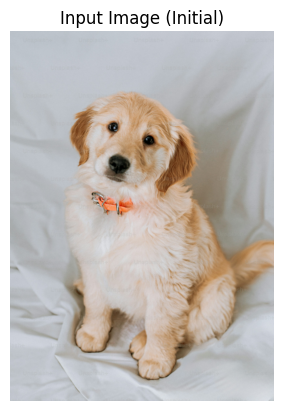

In [22]:
# 📌 Neural Style Transfer - Step 6: Initialize input image & optimizer

# Option 1: start from the content image (recommended)
input_img = content_img.clone()

# Option 2: start from random noise
# input_img = torch.randn(content_img.data.size(), device=device)

# We want the input to require gradients so we can optimize it
input_img.requires_grad_(True)

# Use LBFGS optimizer (works well for NST)
optimizer = optim.Adam([input_img], lr=0.01)

# For tracking:
print("Input image initialized:")
imshow(input_img, title="Input Image (Initial)")


Starting optimization...
Step 0:
  Style Loss : 0.0025
  Content Loss : 0.0000
Step 50:
  Style Loss : 0.0001
  Content Loss : 18.4504
Step 100:
  Style Loss : 0.0001
  Content Loss : 16.4963
Step 150:
  Style Loss : 0.0000
  Content Loss : 14.6989
Step 200:
  Style Loss : 0.0000
  Content Loss : 13.3494
Step 250:
  Style Loss : 0.0000
  Content Loss : 12.3708
Step 300:
  Style Loss : 0.0000
  Content Loss : 11.6218
Step 350:
  Style Loss : 0.0000
  Content Loss : 11.0155
Step 400:
  Style Loss : 0.0000
  Content Loss : 10.5123
Step 450:
  Style Loss : 0.0000
  Content Loss : 10.0915
Step 500:
  Style Loss : 0.0000
  Content Loss : 9.7389
Step 550:
  Style Loss : 0.0000
  Content Loss : 9.4412
Step 600:
  Style Loss : 0.0000
  Content Loss : 9.1894
Step 650:
  Style Loss : 0.0000
  Content Loss : 8.9759
Step 700:
  Style Loss : 0.0000
  Content Loss : 8.7928
Step 750:
  Style Loss : 0.0000
  Content Loss : 8.6356
Step 800:
  Style Loss : 0.0000
  Content Loss : 8.4993
Step 850:
  Style

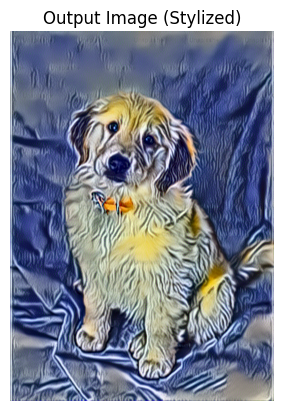

Stylized image saved as 'output_stylized_image.jpg'


In [23]:

import time

num_steps = 1000
style_weight = 1e6
content_weight = 1

print("Starting optimization...")

start_time = time.time()

for step in range(num_steps):
    optimizer.zero_grad()
    model(input_img)

    style_score = sum(sl.loss for sl in style_losses)
    content_score = sum(cl.loss for cl in content_losses)

    loss = style_score * style_weight + content_score * content_weight
    loss.backward()
    optimizer.step()
    input_img.data.clamp_(0, 1)

    if step % 50 == 0:
        print(f"Step {step}:")
        print(f"  Style Loss : {style_score.item():.4f}")
        print(f"  Content Loss : {content_score.item():.4f}")

print(f"Optimization finished in {(time.time() - start_time):.1f} seconds")

imshow(input_img, title="Output Image (Stylized)")

output_image = input_img.cpu().clone().squeeze(0)
output_image = unloader(output_image)
output_image.save("output_stylized_image.jpg")
print("Stylized image saved as 'output_stylized_image.jpg'")
